In [61]:
from typing import Dict, Any, Callable, List, Tuple, Optional
import dill
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertModel, BertTokenizer, DistilBertModel, DistilBertTokenizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import (
   CountVectorizer, TfidfVectorizer
)
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.pipeline import FeatureUnion, Pipeline
import numpy as np
import torch
import re
import json
from transformers import (AdamW, OpenAIGPTDoubleHeadsModel, OpenAIGPTTokenizer)
import umap
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from scipy.sparse import csr_matrix



from utils import *

sns.set()

from sklearn.utils.multiclass import unique_labels

In [2]:
df = pd.read_csv("data/20200325_counsel_chat.csv", encoding='utf-8')
df.head()

,Unnamed: 0,questionID,questionTitle,questionText,questionLink,topic,therapistInfo,therapistURL,answerText,upvotes,views,split
0,0,0,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,https://counselchat.com/questions/can-i-change...,depression,"Sherry Katz, LCSWCouples and Family Therapist,...",https://counselchat.com/therapists/sherry-katz...,"If everyone thinks you're worthless, then mayb...",1,2899,train
1,1,0,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,https://counselchat.com/questions/can-i-change...,depression,"Robin Landwehr, DBH, LPCC, NCCMental Health in...",https://counselchat.com/therapists/robin-landw...,"Hello, and thank you for your question and see...",1,3514,train
2,2,0,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,https://counselchat.com/questions/can-i-change...,depression,Lee KingI use an integrative approach to treat...,https://counselchat.com/therapists/lee-king,First thing I'd suggest is getting the sleep y...,0,5,train
3,3,0,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,https://counselchat.com/questions/can-i-change...,depression,"Shauntai Davis-YearginPersonalized, private on...",https://counselchat.com/therapists/shauntai-da...,Therapy is essential for those that are feelin...,0,31,train
4,4,0,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,https://counselchat.com/questions/can-i-change...,depression,Jordan WhiteLicensed Social Worker at Oak Root...,https://counselchat.com/therapists/jordan-white,I first want to let you know that you are not ...,0,620,train


## Descriptive statistics

In [3]:
# Number of counselors
df.groupby("therapistURL").agg("count").shape

(307, 11)

In [4]:
# Number of Topics
len(set(df["topic"].tolist()))

31

In [5]:
# Number of responses
df.shape

(2129, 12)

In [6]:
# Number of questions
len(set(df["questionLink"].tolist()))

824

In [7]:
# Average number of responses to questions
df.groupby("questionLink").agg("count").describe()

,Unnamed: 0,questionID,questionTitle,questionText,topic,therapistInfo,therapistURL,answerText,upvotes,views,split
count,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000
mean,2.583738,2.583738,2.583738,2.583738,2.583738,2.583738,2.583738,2.583738,2.583738,2.583738,2.583738
std,4.982621,4.982621,4.982621,4.982621,4.982621,4.982621,4.982621,4.982621,4.982621,4.982621,4.982621
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000


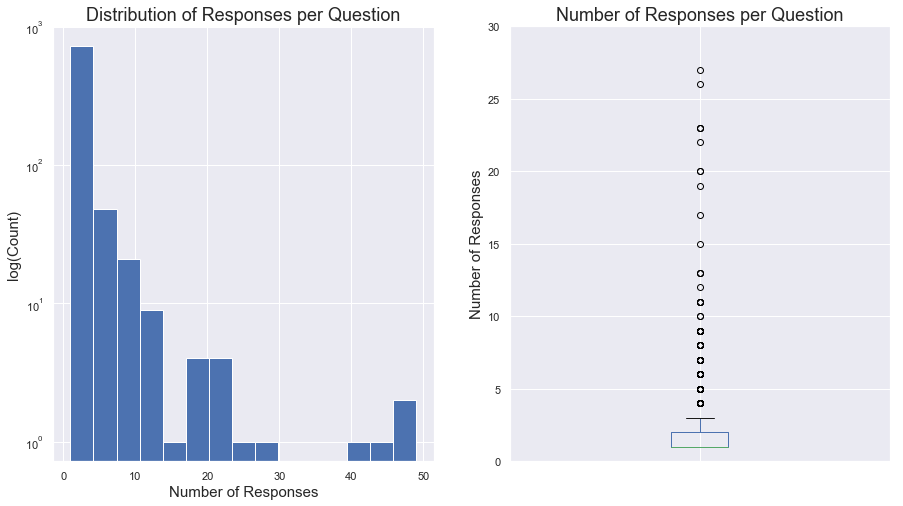

In [8]:
# Distribution of number of responses
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
df.groupby("questionID").agg("count")["questionLink"].plot.hist(bins=15, ax=axs[0], logy=True)
axs[0].set_title("Distribution of Responses per Question", fontsize=18)
axs[0].set_ylabel("log(Count)", fontsize=15)
axs[0].set_xlabel("Number of Responses", fontsize=15)


# Number of responses
df.groupby("questionID").agg("count")["questionLink"].plot.box(ax=axs[1])
axs[1].set_title("Number of Responses per Question", fontsize=18)
axs[1].set_ylabel("Number of Responses", fontsize=15)
axs[1].set_xticklabels("")
axs[1].set_ylim([0, 30])
plt.savefig("figures/number_responses.png")

In [9]:
df.groupby("questionID").agg("count").sort_values("questionID")

,Unnamed: 0,questionTitle,questionText,questionLink,topic,therapistInfo,therapistURL,answerText,upvotes,views,split
questionID,,,,,,,,,,,
0,23,23,23,23,23,23,23,23,23,23,23
1,49,49,49,49,49,49,49,49,49,49,49
2,11,11,11,11,11,11,11,11,11,11,11
3,13,13,13,13,13,13,13,13,13,13,13
4,3,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...
880,1,1,1,1,1,1,1,1,1,1,1
881,1,1,1,1,1,1,1,1,1,1,1
882,3,3,3,3,3,3,3,3,3,3,3


In [10]:
# Average number of responses to questions by topic type
df.groupby(["questionLink", "topic"]).agg("count").reset_index().head()

,questionLink,topic,Unnamed: 0,questionID,questionTitle,questionText,therapistInfo,therapistURL,answerText,upvotes,views,split
0,https://counselchat.com/questions/a-friend-of-...,workplace-relationships,4,4,4,4,4,4,4,4,4,4
1,https://counselchat.com/questions/about-a-year...,marriage,4,4,4,4,4,4,4,4,4,4
2,https://counselchat.com/questions/all-i-can-do...,self-esteem,1,1,1,1,1,1,1,1,1,1
3,https://counselchat.com/questions/am-i-a-lesbi...,intimacy,1,1,1,1,1,1,1,1,1,1
4,https://counselchat.com/questions/am-i-being-p...,intimacy,1,1,1,1,1,1,1,1,1,1


In [11]:
# number of counts topic
df.groupby("topic").agg("count").describe()

,Unnamed: 0,questionID,questionTitle,questionText,questionLink,therapistInfo,therapistURL,answerText,upvotes,views,split
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,68.677419,68.677419,68.677419,68.677419,68.677419,68.677419,68.677419,68.677419,68.677419,68.677419,68.677419
std,85.624135,85.624135,85.624135,85.624135,85.624135,85.624135,85.624135,85.624135,85.624135,85.624135,85.624135
min,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
25%,10.500000,10.500000,10.500000,10.500000,10.500000,10.500000,10.500000,10.500000,10.500000,10.500000,10.500000
50%,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
75%,79.500000,79.500000,79.500000,79.500000,79.500000,79.500000,79.500000,79.500000,79.500000,79.500000,79.500000
max,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000


In [12]:
df.groupby("topic").agg("count")["questionID"].describe()

count     31.000000
mean      68.677419
std       85.624135
min        3.000000
25%       10.500000
50%       34.000000
75%       79.500000
max      330.000000
Name: questionID, dtype: float64

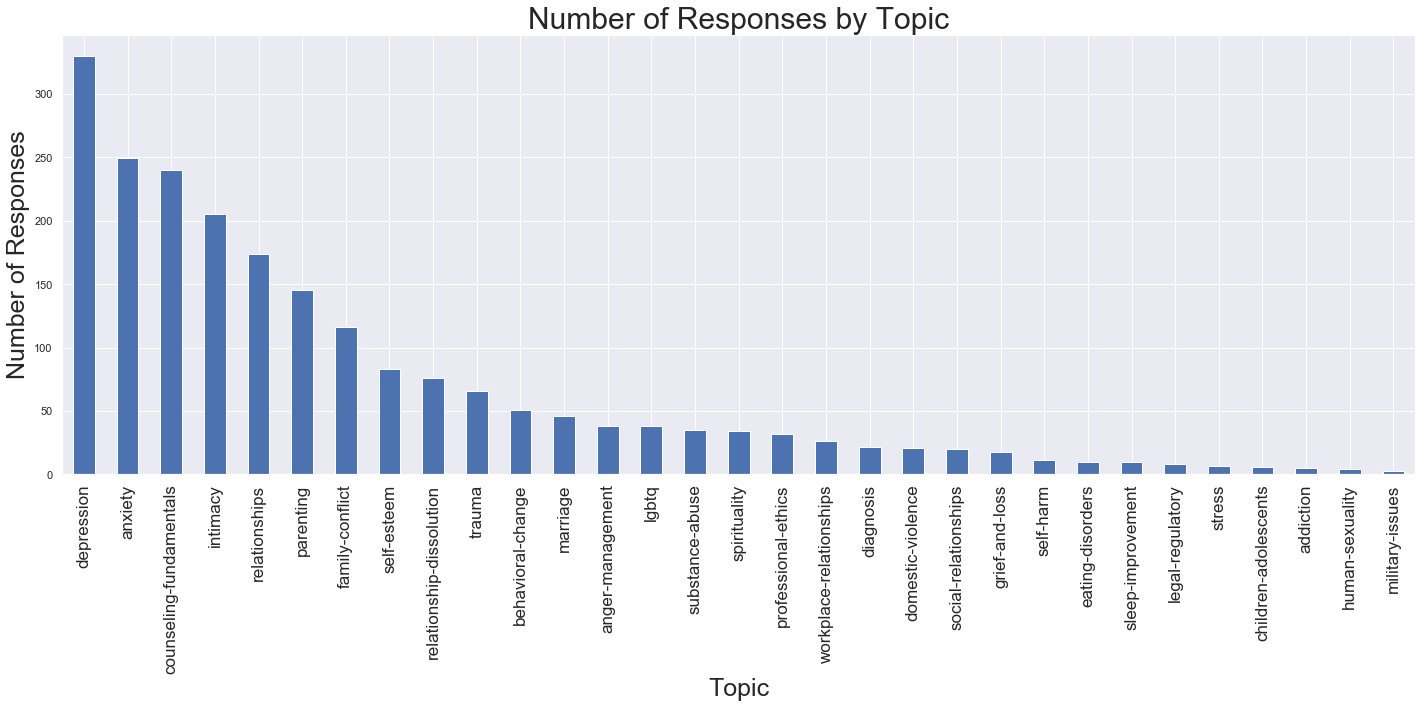

In [13]:
# Distribution of answers by topic
fig, ax = plt.subplots(figsize=(20, 10))
df.groupby("topic").agg("count")["questionID"].sort_values(ascending=False).plot.bar(ax=ax)
ax.set_title("Number of Responses by Topic", fontsize=30)
ax.set_xlabel("Topic", fontsize=25)
ax.set_ylabel("Number of Responses", fontsize=25)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=17)
plt.tight_layout()
plt.savefig("figures/responses_by_topics_count.png")

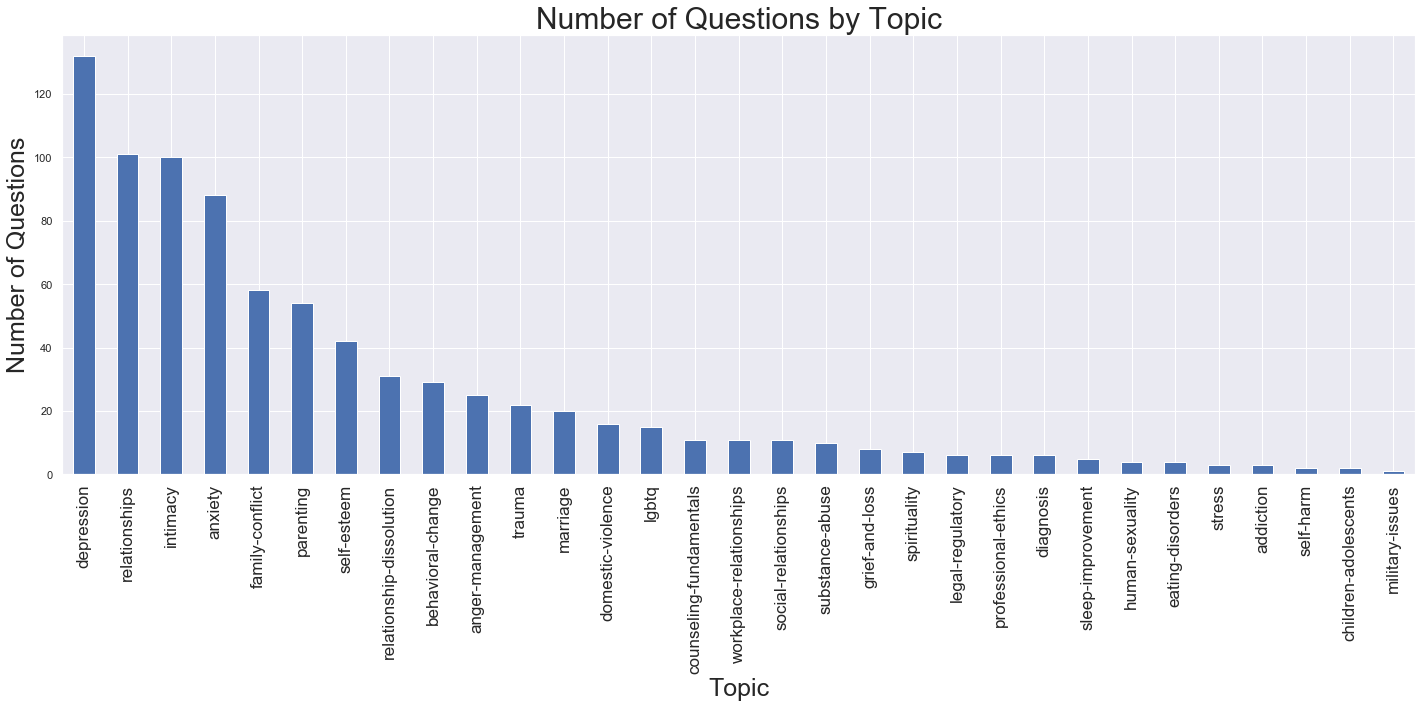

In [14]:
# Number of questsions asked per topic
fig, ax = plt.subplots(figsize=(20, 10))
df.groupby(["topic", "questionID"]).agg("count").reset_index().groupby("topic").agg("count")["questionID"].sort_values(ascending=False).plot.bar(ax=ax)
ax.set_title("Number of Questions by Topic", fontsize=30)
ax.set_ylabel("Number of Questions", fontsize=25)
ax.set_xlabel("Topic", fontsize=25)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=17)
plt.tight_layout()
plt.savefig("figures/number_of_questions_by_topic.png")

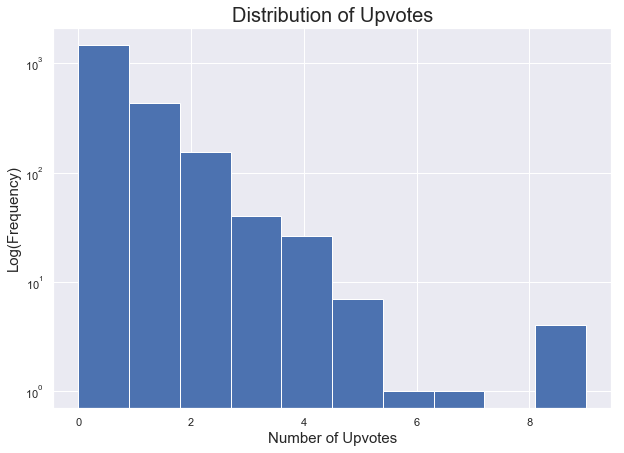

In [15]:
# Distribution of response likes
# Distribution of empathy in responses
fig, ax = plt.subplots(figsize=(10, 7))
df["upvotes"].astype(int).plot.hist(bins=10, ax=ax, logy=True)
ax.set_xlabel("Number of Upvotes", fontsize=15)
ax.set_ylabel("Log(Frequency)", fontsize=15)
ax.set_title("Distribution of Upvotes", fontsize=20)
plt.savefig("figures/upvote_hist.png")

In [16]:
df["upvotes"].describe()

count    2129.000000
mean        0.489901
std         0.942429
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         9.000000
Name: upvotes, dtype: float64

In [17]:
df["has_upvote"] = df["upvotes"].apply(lambda x: 1 if int(x) > 0 else 0)
df["has_upvote"].sum() / df.shape[0]

0.3104744011272898

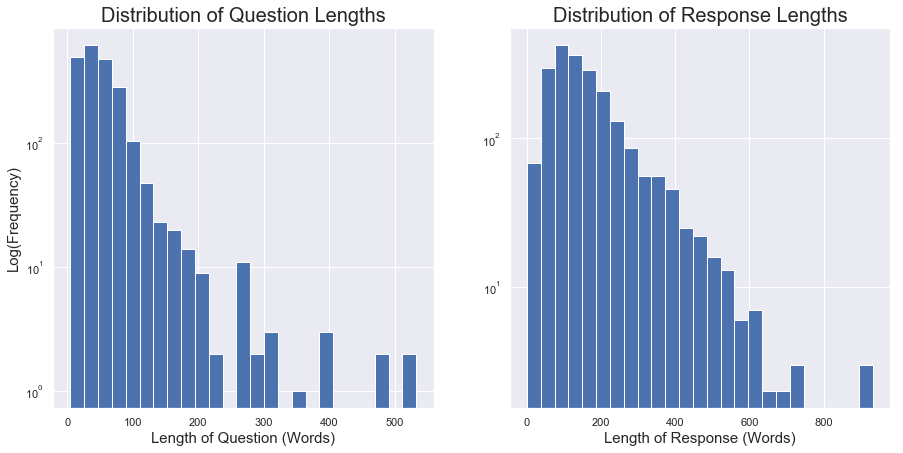

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))


# Average Length of Question
df["questionLength"] = df["questionText"].apply(lambda x: len(x.split(" ")))
df["questionLength"].astype(int).plot.hist(bins=25, ax=axs[0], logy=True)
axs[0].set_xlabel("Length of Question (Words)", fontsize=15)
axs[0].set_ylabel("Log(Frequency)", fontsize=15)
axs[0].set_title("Distribution of Question Lengths", fontsize=20)
plt.savefig("figures/question_length_hist.png")

# Average Length of response
df["responseLength"] = df["answerText"].apply(lambda x: len(x.split(" ")))
df["responseLength"].astype(int).plot.hist(bins=25, ax=axs[1], logy=True)
axs[1].set_xlabel("Length of Response (Words)", fontsize=15)
axs[1].set_title("Distribution of Response Lengths", fontsize=20)
axs[1].set_ylabel("", fontsize=15)
plt.savefig("figures/response_length_hist.png")

In [20]:
# Questions vs statements
titles = list(set(df["questionTitle"].tolist()))
questions = [x for x in titles if x[-1] == "?"]
statements = [x for x in titles if x[-1] != "?"]
print(len(questions))
print(len(statements))

560
258


## Predict Upvotes

In [21]:
x_train = df[df["split"] == "train"]
y_train = x_train["has_upvote"]
x_val = df[df["split"] == "val"]
y_val = x_val["has_upvote"]

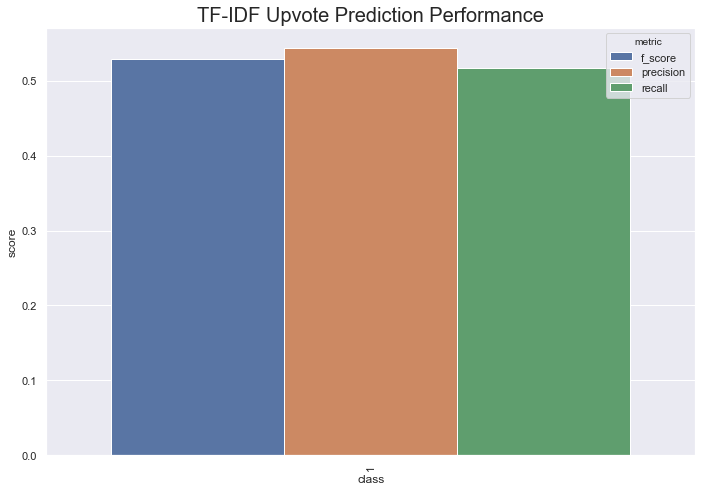

In [22]:
classifier = svm.LinearSVC(C=1.0, class_weight="balanced")

svm_model = Pipeline(
    [
        ("tfidf", TfidfVectorizer(ngram_range=(1, 3))),
        ("classifier", classifier),
    ]
)

svm_model.fit(x_train["answerText"], y_train)
svm_preds = svm_model.predict(x_val["answerText"])

svm_perf_df = calculate_classification_metrics(svm_preds, y_val)
svm_ax = visualize_performance(svm_perf_df[svm_perf_df["class"] == 1],
                              ["f_score", "precision", "recall"],
                              use_class_names=False,
                              title="TF-IDF Upvote Prediction Performance")


In [27]:
# Examine top features
coefs = svm_model.named_steps["classifier"].coef_
if type(coefs) == csr_matrix:
    coefs.toarray().tolist()[0]
else:
    coefs.tolist()
feature_names = svm_model.named_steps["tfidf"].get_feature_names()
coefs_and_features = list(zip(coefs[0], feature_names))
top_features = sorted(coefs_and_features, key=lambda x: abs(x[0]), reverse=True)[:25]

In [ ]:
# Train BERT Model
classifier = svm.LinearSVC(C=1.0, class_weight="balanced")

dbt = BertTransformer(DistilBertTokenizer.from_pretrained("distilbert-base-uncased"),
                      DistilBertModel.from_pretrained("distilbert-base-uncased"),
                      embedding_func=lambda x: x[0][:, 0, :].squeeze(),
                      max_length=150)

bert_model = Pipeline(
    [
        ("vectorizer", dbt),
        ("classifier", classifier),
    ]
)

bert_model.fit(x_train["answerText"], y_train)


(<Figure size 720x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1897b0f90>)

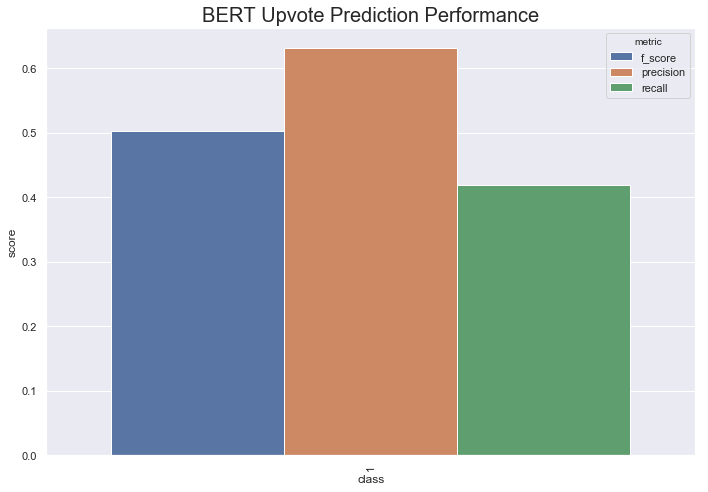

In [65]:
bert_preds = bert_model.predict(x_val["answerText"])

bert_perf_df = calculate_classification_metrics(bert_preds, y_val)
visualize_performance(bert_perf_df[bert_perf_df["class"] == 1],
                      ["f_score", "precision", "recall"],
                      title="BERT Upvote Prediction Performance")

In [101]:
# Train BERT Model
classifier = svm.LinearSVC(C=1.0, class_weight="balanced")

dbt = BertTransformer(DistilBertTokenizer.from_pretrained("distilbert-base-uncased"),
                      DistilBertModel.from_pretrained("distilbert-base-uncased"),
                      embedding_func=lambda x: x[0][:, 0, :].squeeze(),
                      max_length=150)

tf_idf = Pipeline([
    ("vect", CountVectorizer(analyzer='word', ngram_range=(1, 2))),
    ("tfidf", TfidfTransformer())
    ])

combined_model = Pipeline([
    ("union", FeatureUnion(transformer_list=[
        ("bert", dbt),
        ("tf_idf", tf_idf)
        ])),
        ("classifier", classifier),
    ])

combined_model.fit(x_train["answerText"], y_train)

/Users/tetracycline/.local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('bert',
                                                 BertTransformer(bert_model=None,
                                                                 bert_tokenizer=None,
                                                                 embedding_func=<function <lambda> at 0x16bc149e0>,
                                                                 max_length=150)),
                                                ('tf_idf',
                                                 Pipeline(memory=None,
                                                          steps=[('vect',
                                                                  CountVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  deco

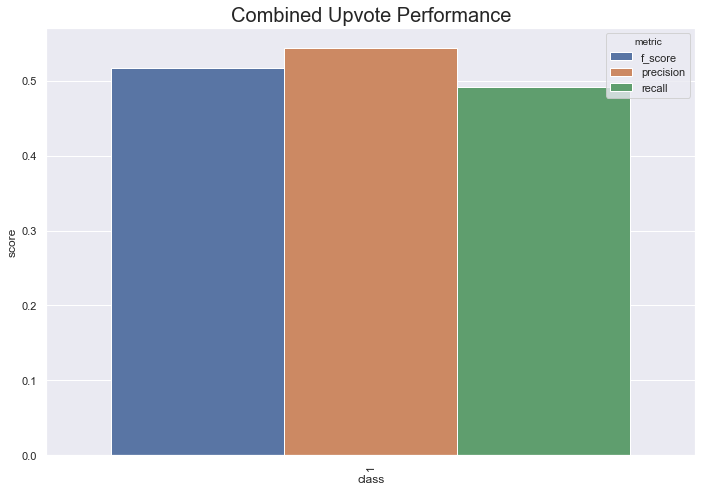

In [102]:
combined_preds = combined_model.predict(x_val["answerText"])

combined_perf_df = calculate_classification_metrics(combined_preds, y_val)
visualize_performance(combined_perf_df[combined_perf_df["class"] == 1],
                      ["f_score", "precision", "recall"],
                      title="Combined Upvote Performance")

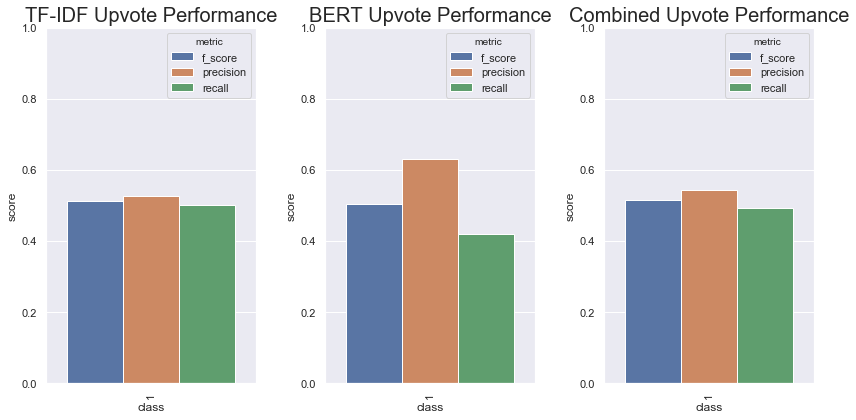

In [107]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
visualize_performance(svm_perf_df[svm_perf_df["class"] == 1],
                      ["f_score", "precision", "recall"],
                      title="TF-IDF Upvote Performance",
                      ax=axs[0],
                      ylim=[0, 1])

visualize_performance(bert_perf_df[bert_perf_df["class"] == 1],
                      ["f_score", "precision", "recall"],
                      title="BERT Upvote Performance",
                      ax=axs[1],
                     ylim=[0, 1])

visualize_performance(combined_perf_df[combined_perf_df["class"] == 1],
                      ["f_score", "precision", "recall"],
                      title="Combined Upvote Performance",
                      ax=axs[2],
                      ylim=[0, 1])
plt.savefig("figures/upvote_performance.png")

In [106]:
svm_perf_df

,class,f_score,precision,recall,support,kappa,accuracy
0,0,0.751092,0.741379,0.761062,113,0.264159,0.67052
1,1,0.512821,0.526316,0.500000,60,0.264159,0.67052


In [105]:
bert_perf_df

,class,f_score,precision,recall,support,kappa,accuracy
0,0,0.650246,0.568966,0.758621,87,0.177569,0.589595
1,1,0.503497,0.631579,0.418605,86,0.177569,0.589595


In [104]:
combined_perf_df

,class,f_score,precision,recall,support,kappa,accuracy
0,0,0.743363,0.724138,0.763636,110,0.26101,0.66474
1,1,0.516667,0.543860,0.492063,63,0.26101,0.66474


In [ ]:
# Get informative features


## Predict Topics

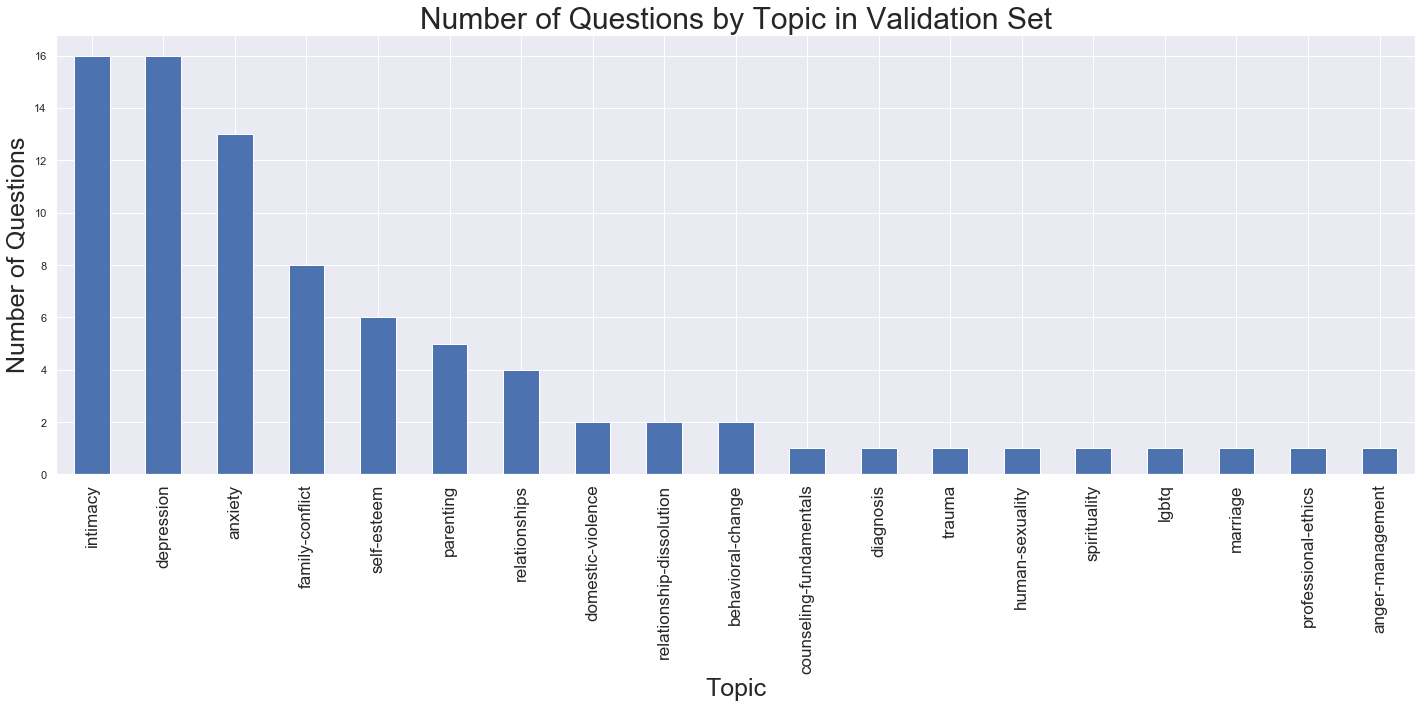

In [29]:
# Number of questsions asked per topic in validation set
fig, ax = plt.subplots(figsize=(20, 10))
x_val.groupby(["topic", "questionID"]).agg("count").reset_index().groupby("topic").agg("count")["questionID"].sort_values(ascending=False).plot.bar(ax=ax)
ax.set_title("Number of Questions by Topic in Validation Set", fontsize=30)
ax.set_ylabel("Number of Questions", fontsize=25)
ax.set_xlabel("Topic", fontsize=25)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=17)
plt.tight_layout()
plt.savefig("figures/number_of_questions_by_topic_validation_set.png")

In [ ]:
classifier = svm.LinearSVC(C=1.0, class_weight="balanced")

dbt = BertTransformer(DistilBertTokenizer.from_pretrained("distilbert-base-uncased"),
                      DistilBertModel.from_pretrained("distilbert-base-uncased"),
                      embedding_func=lambda x: x[0][:, 0, :].squeeze(),
                      max_length=150)

topics_model = Pipeline(
    [
        ("vectorizer", dbt),
        ("classifier", classifier),
    ]
)

topics_model.fit(x_train["answerText"], x_train["topic"])

In [ ]:
topics_preds = topics_model.predict(x_val["answerText"])

/Users/tetracycline/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/tetracycline/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


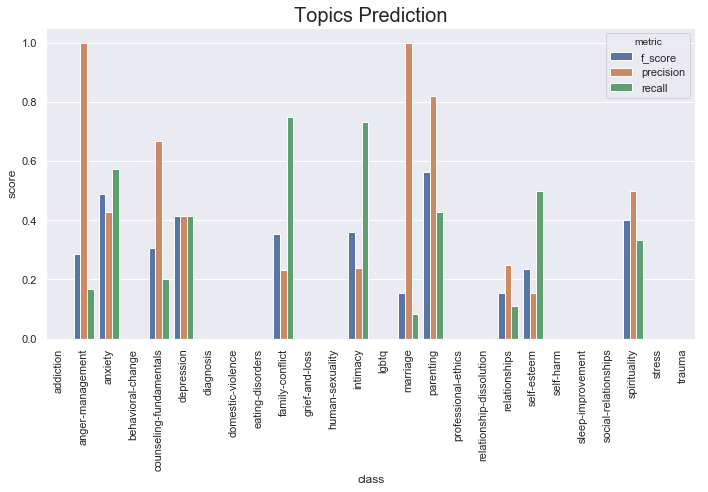

In [29]:
topics_perf_df = calculate_classification_metrics(topics_preds, x_val["topic"])
visualize_performance(topics_perf_df, ["f_score", "precision", "recall"], title="Topics Prediction")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
reducer = umap.UMAP(n_components=2)
reduced = reducer.fit_transform(dbt.transform(df["answerText"]))

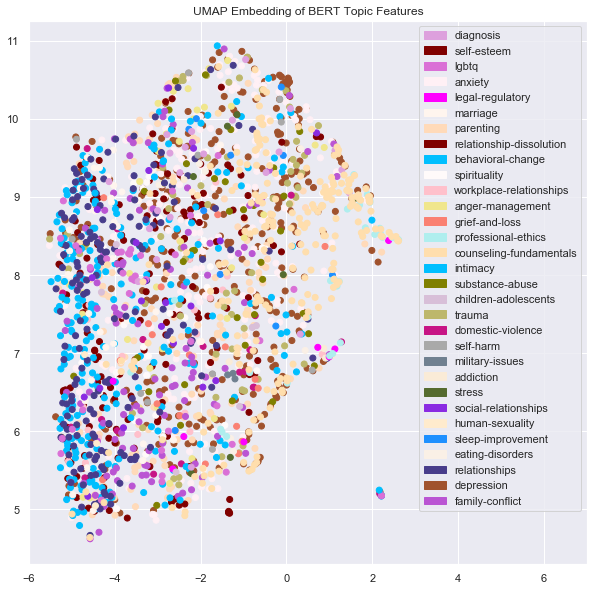

In [72]:
color_names = np.random.choice([k for k in mcolors.CSS4_COLORS.keys()], len(set(df['topic'].tolist())))
color_map = {topic: color for topic, color in zip(set(df["topic"].tolist()), color_names)}
fig, ax = plt.subplots(figsize=(10, 10))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=[color_map[x] for x in df["topic"].tolist()])
ax.set_title("UMAP Embedding of BERT Topic Features")
ax.set_xlim([-6, 7])
patches = []
for topic, color in color_map.items():
    patches.append(mpatches.Patch(color=color, label=topic))
plt.legend(handles=patches)
plt.savefig("figures/umap_topic_bert_features.png")
plt.show()


In [73]:
df["umap_1"] = reduced[:, 0]
df["umap_2"] = reduced[:, 1]

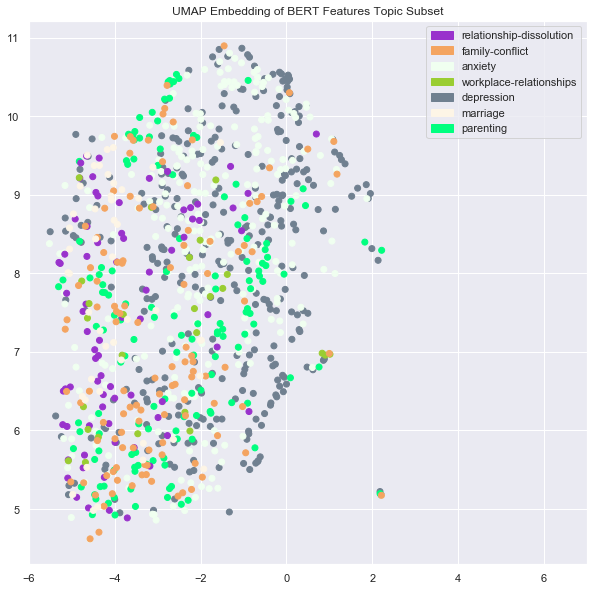

In [92]:
# Examine top performers
topics_to_view = ["workplace-relationships", "counseling_fundamentals", "depression", "anxiety", "family-conflict",
                 "marriage", "parenting", "relationship-dissolution"]
temp_df = df[df["topic"].isin(topics_to_view)]
color_names = np.random.choice([k for k in mcolors.CSS4_COLORS.keys()], len(set(temp_df['topic'].tolist())))
color_map = {topic: color for topic, color in zip(set(temp_df["topic"].tolist()), color_names)}


fig, ax = plt.subplots(figsize=(10, 10))
scatter = plt.scatter(temp_df["umap_1"], temp_df["umap_2"], c=[color_map[x] for x in temp_df["topic"].tolist()])
ax.set_title("UMAP Embedding of BERT Features Topic Subset")
ax.set_xlim([-6, 7])
patches = []
for topic, color in color_map.items():
    patches.append(mpatches.Patch(color=color, label=topic))
plt.legend(handles=patches)
plt.savefig("figures/umap_topic_subset_bert_features.png")
plt.show()

In [32]:
set(x_train["topic"])

{'addiction',
 'anger-management',
 'anxiety',
 'behavioral-change',
 'children-adolescents',
 'counseling-fundamentals',
 'depression',
 'diagnosis',
 'domestic-violence',
 'eating-disorders',
 'family-conflict',
 'grief-and-loss',
 'human-sexuality',
 'intimacy',
 'legal-regulatory',
 'lgbtq',
 'marriage',
 'military-issues',
 'parenting',
 'professional-ethics',
 'relationship-dissolution',
 'relationships',
 'self-esteem',
 'self-harm',
 'sleep-improvement',
 'social-relationships',
 'spirituality',
 'stress',
 'substance-abuse',
 'trauma',
 'workplace-relationships'}

/Users/tetracycline/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/tetracycline/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


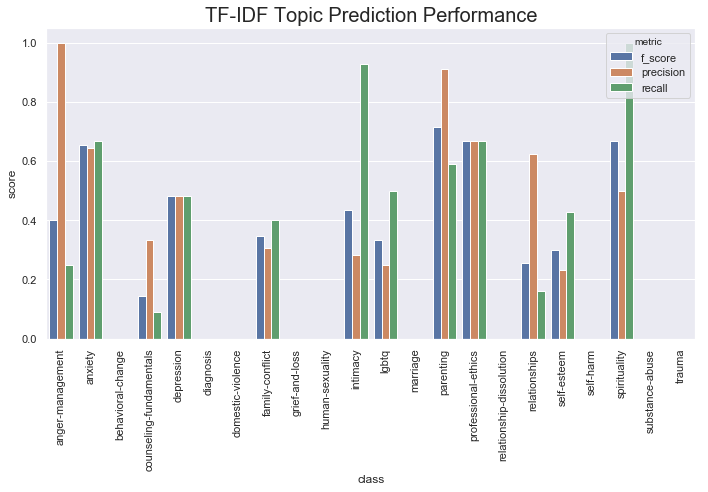

In [37]:
classifier = svm.LinearSVC(C=1.0, class_weight="balanced")

svm_model = Pipeline(
    [
        ("tfidf", TfidfVectorizer(ngram_range=(1, 3))),
        ("classifier", classifier),
    ]
)

svm_model.fit(x_train["answerText"], x_train["topic"])
svm_preds = svm_model.predict(x_val["answerText"])

svm_perf_df = calculate_classification_metrics(svm_preds, x_val["topic"])
svm_ax = visualize_performance(svm_perf_df,
                              ["f_score", "precision", "recall"],
                              title="TF-IDF Topic Prediction Performance")

In [41]:
# Examine top features
coefs = svm_model.named_steps["classifier"].coef_
if type(coefs) == csr_matrix:
    coefs.toarray().tolist()[0]
else:
    coefs.tolist()
feature_names = svm_model.named_steps["tfidf"].get_feature_names()
coefs_and_features = list(zip(coefs[0], feature_names))
top_features = sorted(coefs_and_features, key=lambda x: abs(x[0]), reverse=True)[:25]
top_features

[(0.41124549003359906, '12'),
 (0.3736943612244834, 'duty'),
 (0.3572306947411292, '12 step'),
 (0.2587772656365978, 'relapses'),
 (0.2467989282809322, 'your own interests'),
 (0.24239530368902912, 'is the duty'),
 (0.24239530368902912, 'local attorney'),
 (0.24239530368902912, 'side is'),
 (0.24239530368902912, 'side is the'),
 (0.24239530368902912, 'the counselors'),
 (0.24239530368902912, 'the duty'),
 (0.23860733067825113, 'own interests'),
 (0.23214898054235292, 'state'),
 (0.22936568833964946, 'your relative'),
 (0.21535584351647383, 'phone'),
 (0.21221899563084348, 'legal'),
 (0.2067687207724831, 'your loss'),
 (0.20632925858706935, 'attorney'),
 (0.19604017937134446, 'report'),
 (0.19480293982810193, 'relative'),
 (0.19176493670559122, 'groups that'),
 (0.19176493670559122, 'sobriety'),
 (0.19176493670559122, 'your sobriety'),
 (0.1906867938429202, 'loss'),
 (0.18480981632733448, 'recovery')]

Text(0.5, 0, 'Feature Name')

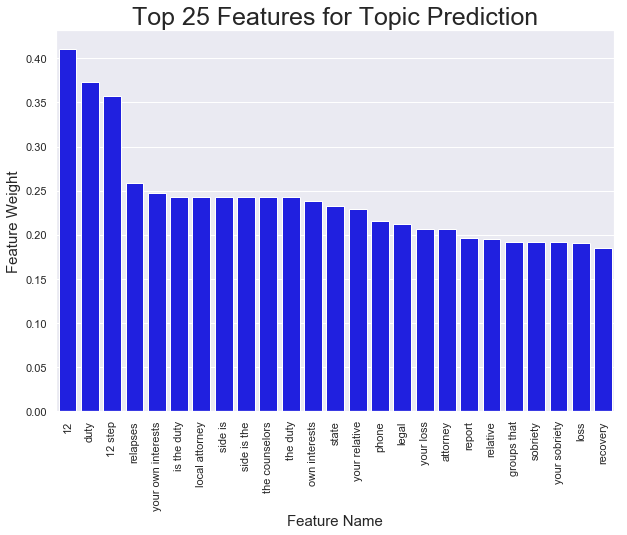

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.barplot(x="features", y="value", data=pd.DataFrame(top_features, columns=["value", 'features']), ax=ax, color="blue")
ax.set_xticklabels([x[1] for x in top_features], rotation=90)
ax.set_title("Top 25 Features for Topic Prediction", fontsize=25)
ax.set_ylabel("Feature Weight", fontsize=15)
ax.set_xlabel("Feature Name", fontsize=15)

# Extract Chat Bot Data

In [3]:
tokenizer_class = OpenAIGPTTokenizer
tokenizer = tokenizer_class.from_pretrained("openai-gpt")

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


In [6]:
d = convert_df_to_conv_ai_dict(df, [""], ["answerText"], tokenizer, max_tokens=250, n_candidates=8)

In [188]:
with open("/Users/tetracycline/repos/convai/data/counsel_chat_250-tokens.json", "w") as json_file:
    json.dump(d, json_file)